In [1]:
import warnings
import pandas as pd
import numpy as np
import pandas_profiling
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
%matplotlib inline

d:\Downloads\New folder\envs\credit_risk\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
d:\Downloads\New folder\envs\credit_risk\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
application_train = pd.read_csv(r'd:\NEU\Credit-Risk-Analysis\data\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv',index_col = 0)
application_test = pd.read_csv(r'd:\NEU\Credit-Risk-Analysis\data\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_test.csv',index_col = 0)
bureau = pd.read_csv(r'd:\NEU\Credit-Risk-Analysis\data\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau.csv')
# bureau_profile = bureau.profile_report(title="Bureau dataset report")
# bureau_profile

In [3]:
print(f'The shape of bureau.csv is: {bureau.shape}')
print(f'Number of unique SK_ID_BUREAU in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Number of unique SK_ID_CURR in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Number of duplicate values in bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')

The shape of bureau.csv is: (1465325, 17)
Number of unique SK_ID_BUREAU in bureau.csv are: 1465325
Number of unique SK_ID_CURR in bureau.csv are: 263491
Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: 210809
Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: 52682
Number of duplicate values in bureau: 0


Number of columns having NaN values: 7 columns


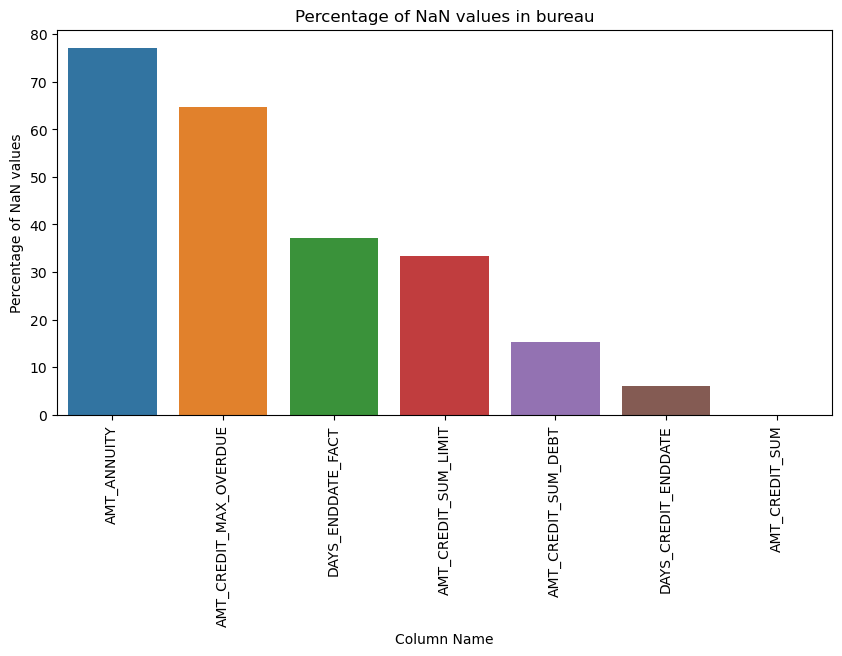

In [4]:
# NaN Columns and Percentages
nan_df_bureau = nan_df_create(bureau)
plot_nan_percent(nan_df_bureau, 'bureau', tight_layout = False, figsize = (10,5))

#### Observation from Bureau.csv

- The bureau.csv file contains close to 1.4M observations, with 17 features. Out of these 17 features, two are SK_ID_CURR and SK_ID_BUREAU.
    - SK_ID_BUREAU is the loan ID of the client's previous loan from other financial institutions. There may be multiple previous loans corresponding to a single SK_ID_CURR which depends on client's borrowing pattern.
    - SK_ID_CURR is the loan ID of client's current loan with Home Credit.
    - The rest of the features contain other stats such as DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.
- Out of 17 features, there are 7 features which contain NaN values. The highest NaN values are observed with the column AMT_ANNUITY which has over 70% missing values.

# EDA

### Merging the TARGETS from application_train to bureau table.

In [5]:
bureau_merge = pd.merge(application_train[["SK_ID_CURR", "TARGET"]], bureau, how='left', on=['SK_ID_CURR'])
# bureau_merge_profile = bureau_merge.profile_report(title="Bureau merged dataset report")
# bureau_merge_profile

### Observation from bureau_merge_profile
- DAYS_CREDIT is highly overall correlated with DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, DAYS_CREDIT_UPDATE.
- CREDIT_DAY_OVERDUE is highly overall correlated with AMT_CREDIT_SUM_OVERDUE
- AMT_CREDIT_SUM_OVERDUE is highly overall correlated with CREDIT_DAY_OVERDUE 
- DAYS_CREDIT_ENDDATE is highly overall correlated with DAYS_CREDIT, DAYS_ENDDATE_FACT, DAYS_CREDIT_UPDATE,AMT_CREDIT_SUM_DEBT
- From correlations heatmap, we can also see that the features don't particularly show good/high correlation with Target as such, except for DAYS_CREDIT feature (0.068). This implies that there isn't a direct linear relation between Target and the features

### Univariate Analysis: CREDIT_ACTIVE

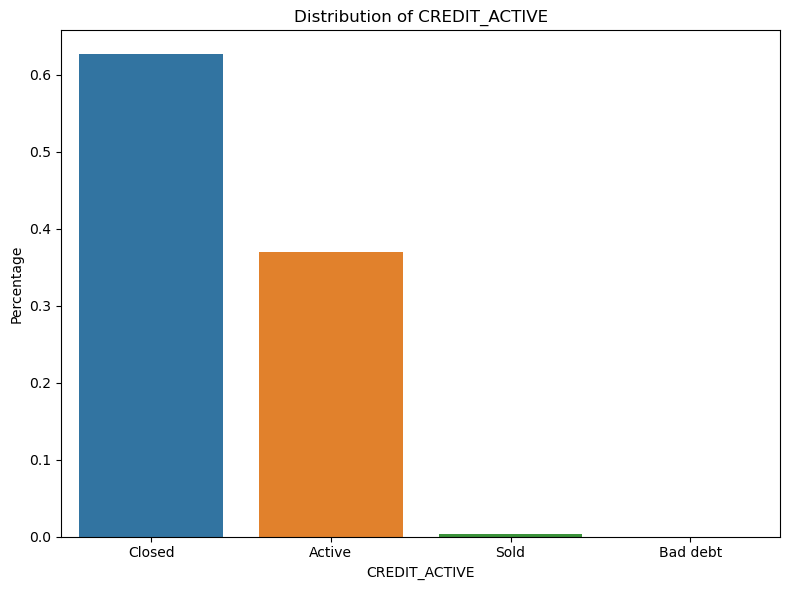

In [6]:
credit_active_counts = bureau_merge['CREDIT_ACTIVE'].value_counts(normalize=True)
# Create a bar plot
plt.figure(figsize=(8, 6), tight_layout=True)
sns.barplot(x=credit_active_counts.index, y=credit_active_counts.values)
# Set plot labels and title
plt.xlabel("CREDIT_ACTIVE")
plt.ylabel("Percentage")
plt.title("Distribution of CREDIT_ACTIVE")

# Show the plot
plt.show()

- In CREDIT_ACTIVE, more than 60% of the applications in the Bureau Data are closed, which is followed by the status being Active. There are very few loans that are 'Sold' or considered to be 'Bad Debt'.

### Univariate Analysis: Days_Credit

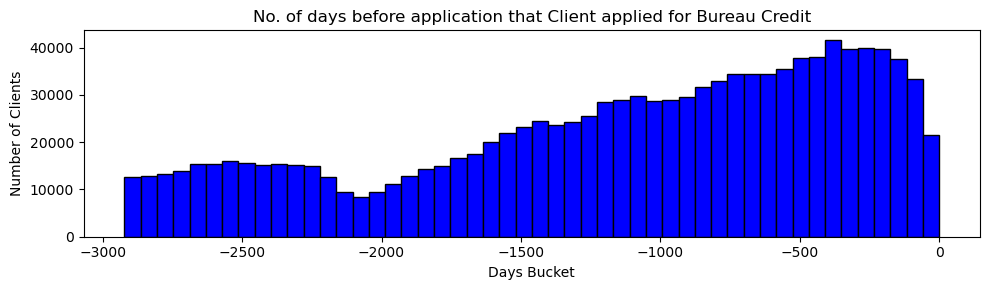

In [7]:
plt.figure(figsize=(10,3), tight_layout=True)
plt.hist(bureau_merge['DAYS_CREDIT'].values, bins=50, edgecolor='black', color='blue')
plt.title('No. of days before application that Client applied for Bureau Credit')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

- Most of the clients applied for Bureau Credit less than 500 days before the date of loan application.

###  Univariate Analysis: Credit_Day_Overdue

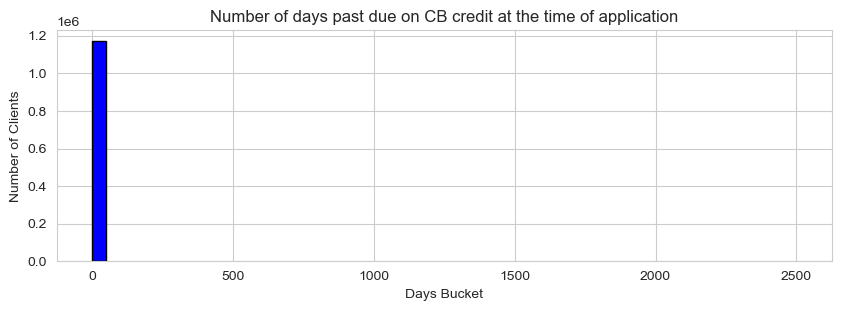

In [25]:
bin_edges = [0, 1, 2500]

# Create a histogram with specified bin edges
plt.figure(figsize=(10, 3))
plt.hist(bureau_merge['CREDIT_DAY_OVERDUE'].values, bins=bin_edges, edgecolor='black', color='blue',width=50)

plt.title('Number of days past due on CB credit at the time of application')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

- Most of the clients have a low DPD (close to 0) on CB Credit ( most of the clients have a good payment history and are less likely to default on loans, more likely to repay the loan in full and on time) at the time of their application since the histogram is very peaked near 0. To analyse this further, we will have a look at the respective percentile values as shown below.

In [9]:
percentiles = np.arange(0, 101, 10)
percentile_0_100 = pd.DataFrame({'Percentile': percentiles, 'No. of days past due on CB Credit': np.round([np.percentile(bureau['CREDIT_DAY_OVERDUE'].values, i) for i in percentiles], 2)})
percentile_0_100

,Percentile,No. of days past due on CB Credit
0,0,0.0
1,10,0.0
2,20,0.0
3,30,0.0
4,40,0.0
5,50,0.0
6,60,0.0
7,70,0.0
8,80,0.0
9,90,0.0


- There is 0 DPD till the 90th percentile as well, whereas the 100th percentile is a value = 2792.
- We will further zoom into the values between the 99th and 100th percentiles.

In [10]:
percentiles = np.arange(99,100,0.1)
percentile_90_100 = pd.DataFrame({'Percentile': percentiles, 'No. of days past due on CB Credit': np.round([np.percentile(bureau['CREDIT_DAY_OVERDUE'].values, i) for i in percentiles], 2)})
percentile_90_100

,Percentile,No. of days past due on CB Credit
0,99.0,0.0
1,99.1,0.0
2,99.2,0.0
3,99.3,0.0
4,99.4,0.0
5,99.5,0.0
6,99.6,0.0
7,99.7,0.0
8,99.8,15.0
9,99.9,59.0


- We can see from here that only the Top 0.3 percentile of values (3706 observations) over here are non-zeroes.

### Univariate Analysis: Credit_Type

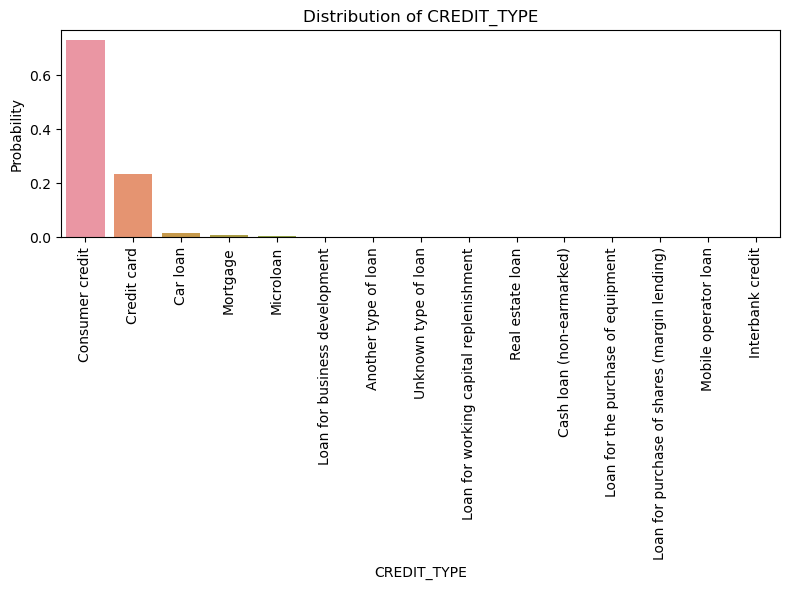

In [11]:
credit_type_counts = bureau['CREDIT_TYPE'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(8, 6), tight_layout=True)
sns.barplot(x=credit_type_counts.index, y=credit_type_counts.values)
# Set plot labels and title
plt.xlabel("CREDIT_TYPE")
plt.ylabel("Probability")
plt.title("Distribution of CREDIT_TYPE")
plt.xticks(rotation=90)
# Show the plot
plt.show()

- Consumer Credit and Credit Cards are the mostly registered credit types in the Credit Bureau.

### Univariate Analysis: CREDIT_CURRENCY

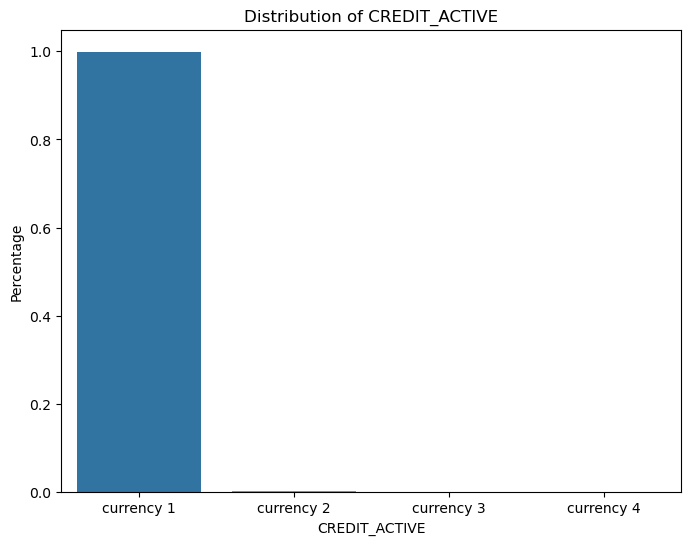

In [12]:
credit_currency_counts = bureau['CREDIT_CURRENCY'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=credit_currency_counts.index, y=credit_currency_counts.values)
# Set plot labels and title
plt.xlabel("CREDIT_ACTIVE")
plt.ylabel("Percentage")
plt.title("Distribution of CREDIT_ACTIVE")

# Show the plot
plt.show()

- Most of recoded currency of the Credit Bureau credit is currency 1 

## Bivariate Analysis

### Bivariate Analysis: Credit_Active vs Days_Credit

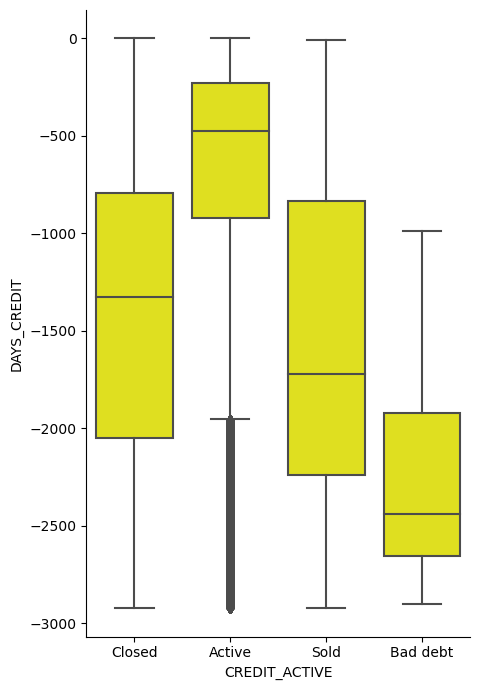

In [13]:
sns.catplot(x="CREDIT_ACTIVE", y="DAYS_CREDIT",\
            data=bureau,color = "yellow",kind="box", height=7, aspect=.7);

- When the Credit Status is Active, it means that the corresponding 'Days_Credit' ie. number of days before Application, the median value is approx. 500 days => this is a good sign, as it suggests that borrowers with active accounts are generally responsible with their credit.

### Bivariate Analysis: 'CREDIT_ACTIVE' vs DEFAULTERS (TARGET=1)

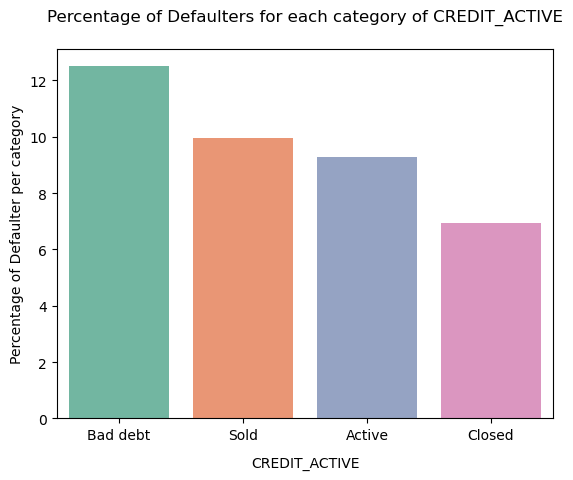

In [14]:
percentage_defaulter_per_category = (bureau_merge['CREDIT_ACTIVE'][bureau_merge.TARGET == 1].value_counts() * 100 / bureau_merge['CREDIT_ACTIVE'].value_counts()).dropna().sort_values(ascending = False)
sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
plt.ylabel('Percentage of Defaulter per category')
plt.xlabel('CREDIT_ACTIVE', labelpad = 10)
# plt.xticks(rotation = rotation)
plt.title(f'Percentage of Defaulters for each category of CREDIT_ACTIVE', pad = 20)
plt.show()

- If we look at the Defaulters Percentage per category, we see that about 13% of people from Bad-Debt defaulted, which is the highest default rate. This is followed by Sold loans and Active Loans. The lowest default rate is for Closed Loans, which show a good history about a client.

### Bivariate Analysis: YEAR_CREDIT vs DEFAULTER (TARGET=1)

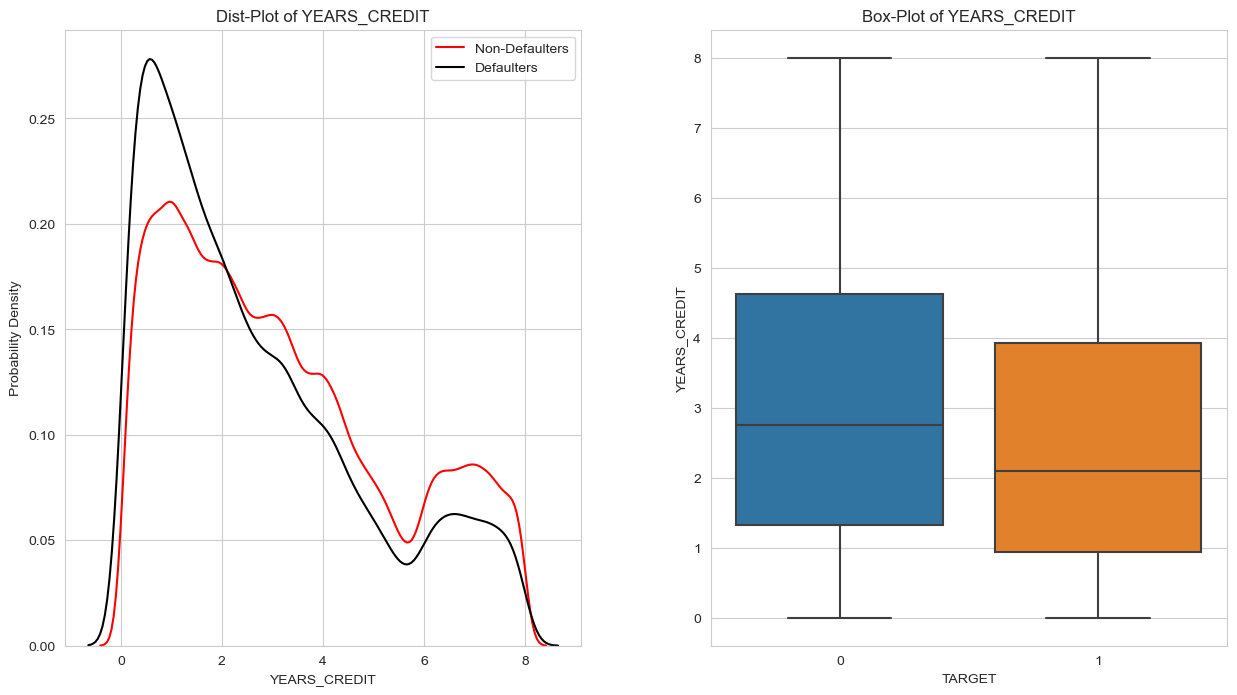

In [15]:
bureau_merge['YEARS_CREDIT'] = bureau_merge['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merge, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (15,8))
_ = bureau_merge.pop('YEARS_CREDIT')

- From the PDF, we see that the Defaulters tend to have higher peaks compared to Non-Defaulters when the number of years are less.. This implies that the applicants who had applied for loans from Credit Bureau recently showed more defaulting tendency than those who had applied long ago. The PDF of Defaulters is also a bit towards left as compared to Non-Defaulters.
- From the box-plot as well, we see that Defaulters usually had less YEARS_CREDIT as compared to Non-Defaulters.

### Bivariate Analysis: DAYS_CREDIT_ENDDATE vs DEFAULTER (TARGET=1)

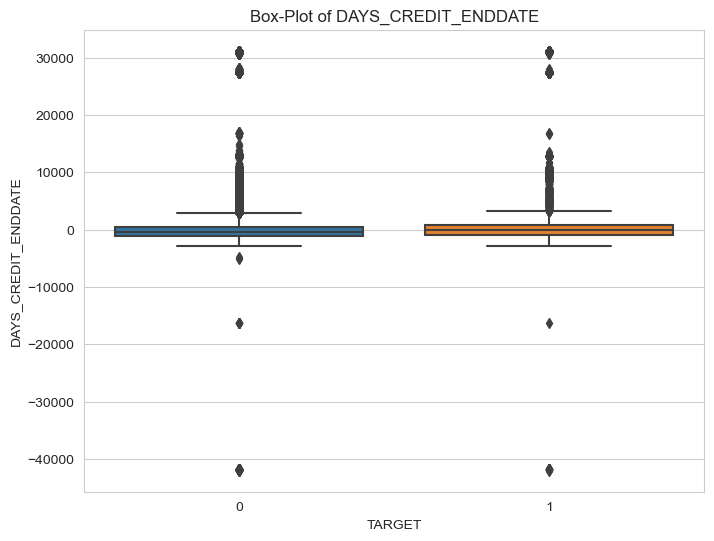

In [16]:
plot_continuous_variables(bureau_merge, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))


- From the above percentile values, and looking at the box-plot, we see that there seems to be erroneous value for DAYS_CREDIT_ENDDATE, where the 0th percentile value dates back to as long as 42060 days or 115 years. This does not make much sense as this implies that the previous loan the client had dates back to 115 years ago. This could be inherited loan too, but we cannot comment so surely about that. We would try to remove these values in the data preprocessing stage.

### Bivariate Analysis: DAYS_CREDIT_UPDATE vs DEFAULTER (TARGET=1)

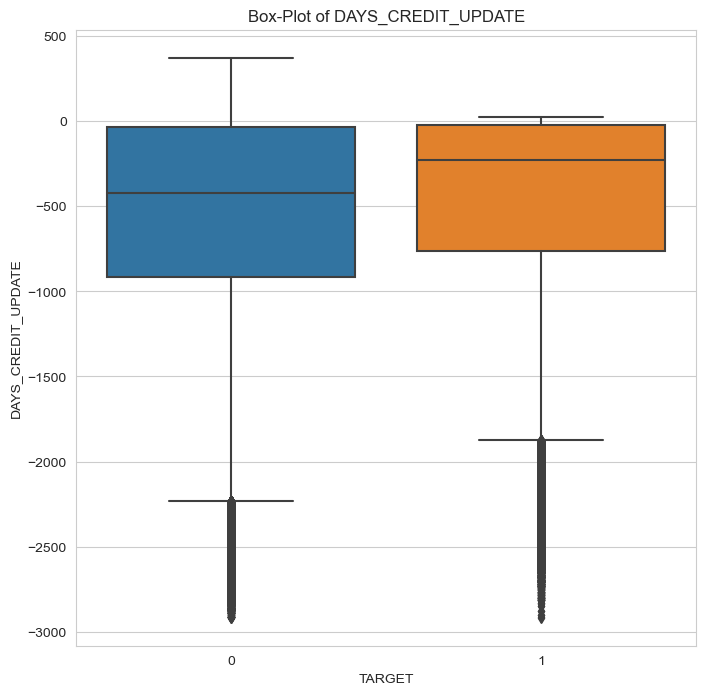

In [17]:
plot_continuous_variables(bureau_merge, 'DAYS_CREDIT_UPDATE', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 400])


- The trend of erroneious values is again very similar to the other days column where this 0th percentile value seems to be erroneous. Also since only the 0th percentile value is so odd, and the rest seem to be fine, thus this value is definitely erroneous. We will be removing this value too.
- From the box-plot, we can say that the Defaulters tend to have a lesser number of days since their Information about the Credit Bureau Credit were received. Their median, 75th percentile values all are lesser than those for Non-Defaulters.

### Bivariate Analysis: DAYS_ENDDATE_FACT vs DEFAULTER (TARGET=1)

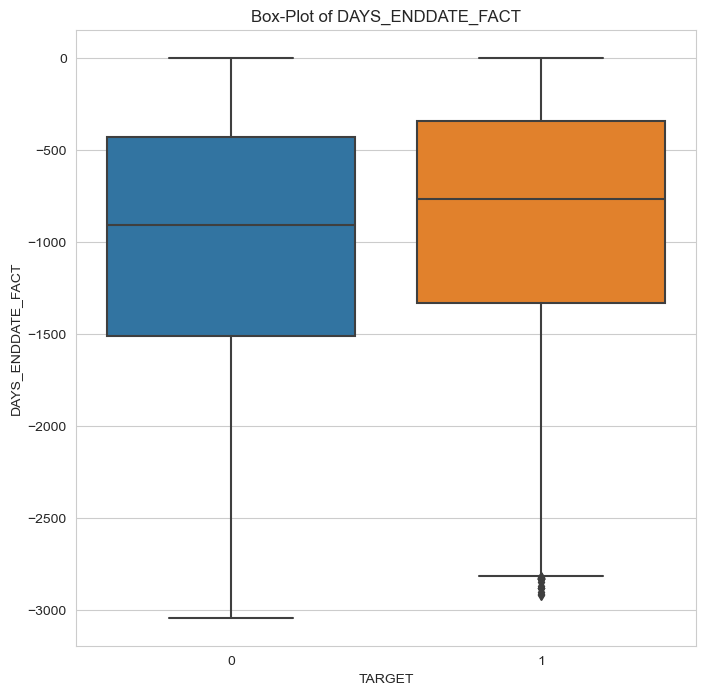

In [18]:
plot_continuous_variables(bureau_merge, 'DAYS_ENDDATE_FACT', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 0])


- Just like previous column, we see that the 0th percentile for this column also seems erroneous, which is 42023 days or ~115 years. We would have to remove these values, as they don't make much sense.
- Looking at the box-plot, we see that the Defaulters tend to have lesser number of days since their Credit Bureau credit had ended. The Non-Defaulters usually have their previous credits ended longer before than Defaulters.